In [1]:
!pip install catboost optuna

In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from catboost import Pool
from sklearn.model_selection import train_test_split as tts
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hse-2nd-step-in-nlp-bootcamp/vacancies_test.csv
/kaggle/input/hse-2nd-step-in-nlp-bootcamp/sample_submission.csv
/kaggle/input/hse-2nd-step-in-nlp-bootcamp/vacancies_train.csv


In [3]:
train = pd.read_csv('/kaggle/input/hse-2nd-step-in-nlp-bootcamp/vacancies_train.csv')
test = pd.read_csv('/kaggle/input/hse-2nd-step-in-nlp-bootcamp/vacancies_test.csv')

<a id="1"></a> <br>
# 1. EDA
Как видно, в датасете 3 текстовые фичи: name, description, key_skills; 
3 категориальные: experience, schedule, employment.
Забегая вперед, хотелось бы обучить берт на текстовых, потом что-то придумать с категориальными.

In [4]:
train.head()

,name,experience,schedule,employment,description,key_skills,salary
0,Водитель-экспедитор,От 3 до 6 лет,Полный день,Полная занятость,"Водитель-экспедитор категории В,С (а\м ГАЗЕЛЬ ...",[],42500.0
1,Кладовщик-комплектовщик/оператор 1С,От 1 года до 3 лет,Полный день,Полная занятость,Обязанности: Списывание материалов в произво...,"['знание пк', 'работа в 1С', 'Работа в команде...",50000.0
2,"Продавец магазина ""Магнит"" (Кировский р-он, В....",Нет опыта,Сменный график,Полная занятость,"В крупнейшую Федеральную сеть магазинов ""Магни...",[],31500.0
3,Администратор магазина (ТЦ Spar),От 1 года до 3 лет,Полный день,Полная занятость,Крупная федеральная сеть магазинов мужской и ж...,[],36700.0
4,Мойщик посуды (кулинария),Нет опыта,Сменный график,Полная занятость,Обязанности: Уборка производственных площадей...,"['Пользователь ПК', 'Грамотная речь', 'Работа ...",37000.0


Насчет целевой переменной, из графика видно что потенциально есть выбросы (слишком высокие зарплаты), а также очень низкие. С первыми можно что-то придумать (скорее всего просто выкинуть), но до сравнения результатов с ними и без руки так и не дошли. А вот со слишком низкие можно посмотреть подробнее.

Text(0.5, 1.0, 'Salary distribution')

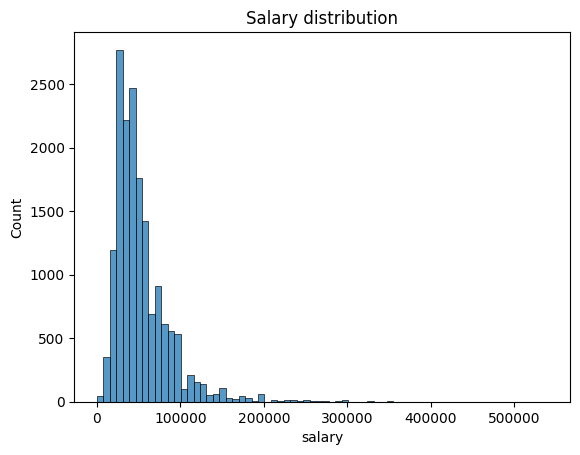

In [ ]:
sns.histplot(data=train.salary, bins=70)
plt.title('Salary distribution')

Text(0.5, 1.0, 'Log salary distribution')

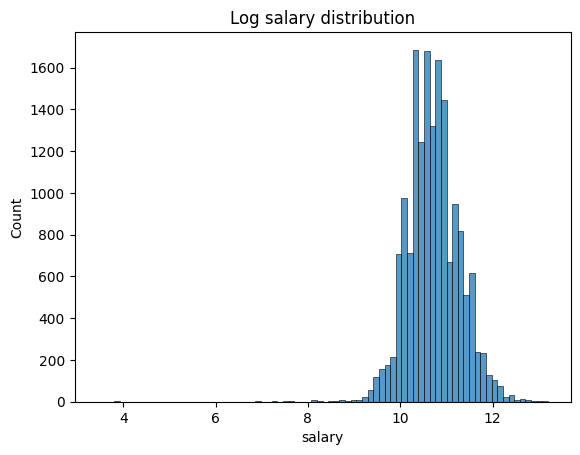

In [ ]:
sns.histplot(data=np.log1p(train.salary), bins=80)
plt.title('Log salary distribution')

Скорее всего, зарплата здесь указана сразу в тысячах, так что это исправить довольно просто.

In [ ]:
train[train.salary < 500]

,name,experience,schedule,employment,description,key_skills,salary
163,Ведущий специалист/Руководитель тендерного отдела,От 3 до 6 лет,Полный день,Полная занятость,Компания-поставщик медицинских расходных матер...,"['Государственные закупки', 'Тендеры', 'Участи...",55.0
2641,Продавец консультант/старший(ТЦ Эльгрин),От 1 года до 3 лет,Полный день,Полная занятость,Должностные обязанности: - консультирование кл...,"['Клиентоориентированность', 'Мерчандайзинг', ...",30.0
9696,Фрезеровщик,От 1 года до 3 лет,Полный день,Полная занятость,Обязанности: Обработка деталей на горизонталь...,"['Пользователь ПК', 'Работа в команде', 'Точно...",60.0
13491,Инженер-экономист,От 1 года до 3 лет,Полный день,Полная занятость,Обязанности Работа с ресурсоснабжающими органи...,"['Работа с большим объемом информации', 'Делов...",45.0
16235,Комплектовщик (Тарасовка),Нет опыта,Сменный график,Полная занятость,Сервис доставки продуктов Ленточка приглашает ...,[],44.0


In [4]:
train.loc[train.salary < 500, 'salary'] = train.loc[train.salary < 500, 'salary'] * 1000

In [ ]:
train.iloc[163]

name           Ведущий специалист/Руководитель тендерного отдела
experience                                         От 3 до 6 лет
schedule                                             Полный день
employment                                      Полная занятость
description    Компания-поставщик медицинских расходных матер...
key_skills     ['Государственные закупки', 'Тендеры', 'Участи...
salary                                                   55000.0
Name: 163, dtype: object

Дальше можно посмотреть на категориальные признаки, насколько сильно они влияют на целевую переменную.

<AxesSubplot:>

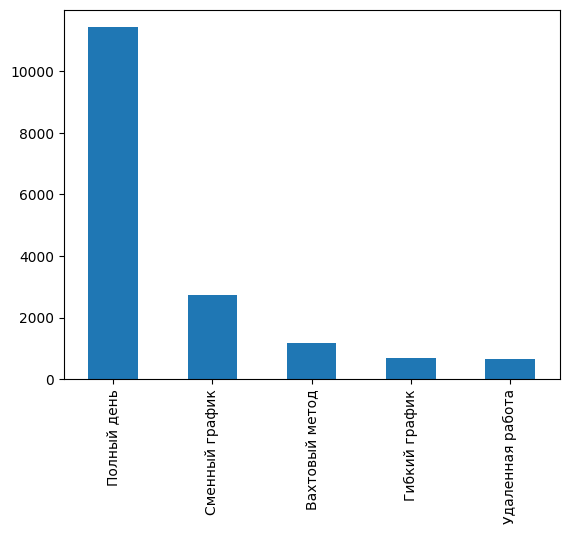

In [ ]:
train.schedule.value_counts().plot(kind='bar')

<AxesSubplot:>

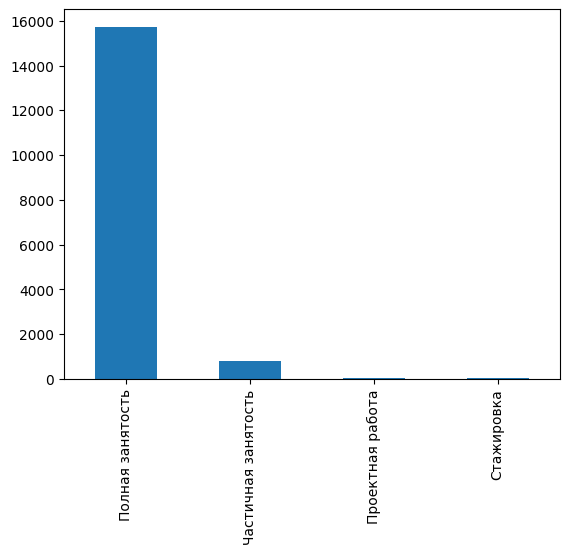

In [ ]:
train.employment.value_counts().plot(kind='bar')

<AxesSubplot:>

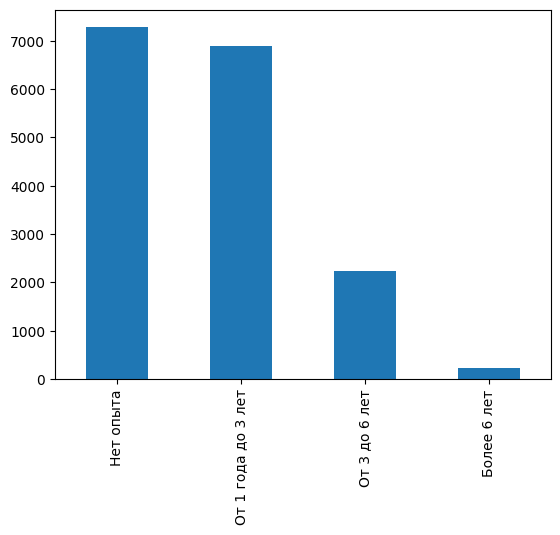

In [ ]:
train.experience.value_counts().plot(kind='bar')

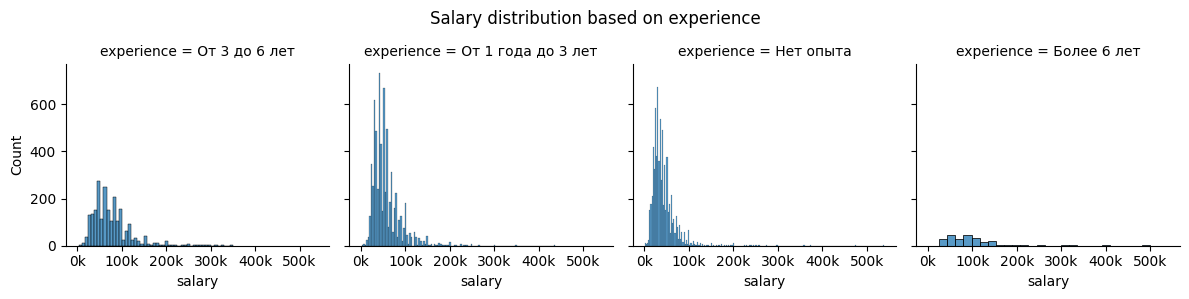

In [ ]:
import matplotlib.ticker as mticker


def format_thousands(x, pos):
    return f"{int(x/1000)}k"
formatter = mticker.FuncFormatter(format_thousands)

g = sns.FacetGrid(train, col="experience", height=3, aspect=1)
g.map(sns.histplot, 'salary')
plt.gca().xaxis.set_major_formatter(formatter)
g.fig.suptitle('Salary distribution based on experience')
g.fig.subplots_adjust(top=0.8)

Также я пробовал сделать что-то с key_skills, например посчитать их количество, но результата это не дало.

In [ ]:
import ast

<AxesSubplot:xlabel='num_skills'>

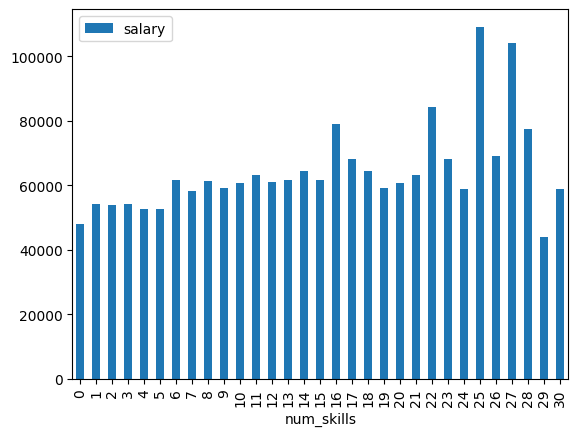

In [ ]:
def count_skills(x):
    return len(ast.literal_eval(x))

train2 = train.copy()
train2['num_skills'] = train2.key_skills.apply(count_skills)
train2.groupby('num_skills').mean('salary').plot(kind='bar')

In [5]:
X = train.drop(columns=['salary'])
y = train.salary

In [5]:
X.head()

,name,experience,schedule,employment,description,key_skills
0,Водитель-экспедитор,От 3 до 6 лет,Полный день,Полная занятость,"Водитель-экспедитор категории В,С (а\м ГАЗЕЛЬ ...",[]
1,Кладовщик-комплектовщик/оператор 1С,От 1 года до 3 лет,Полный день,Полная занятость,Обязанности: Списывание материалов в произво...,"['знание пк', 'работа в 1С', 'Работа в команде..."
2,"Продавец магазина ""Магнит"" (Кировский р-он, В....",Нет опыта,Сменный график,Полная занятость,"В крупнейшую Федеральную сеть магазинов ""Магни...",[]
3,Администратор магазина (ТЦ Spar),От 1 года до 3 лет,Полный день,Полная занятость,Крупная федеральная сеть магазинов мужской и ж...,[]
4,Мойщик посуды (кулинария),Нет опыта,Сменный график,Полная занятость,Обязанности: Уборка производственных площадей...,"['Пользователь ПК', 'Грамотная речь', 'Работа ..."


In [ ]:
X_train, X_test, y_train, y_test = tts(X, y, train_size=0.8, random_state=1)

In [ ]:
y_train.head()

11383    56000.0
14975    52500.0
1543     20000.0
2181     25000.0
1814     68000.0
Name: salary, dtype: float64

<a id="2"></a> <br>
# 2. Baseline
В качестве бейзлайна можно попробовать catboost, сразу в связке с optuna, интересно сколько он сможет выдать.

In [ ]:
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 1, 6),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 10, 5000),
        "cat_features": ['experience', 'schedule', 'employment'],
        "text_features": ['name', 'description', 'key_skills'],
        'task_type': 'GPU'
    }

    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    return score

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2023-08-20 19:06:00,752] A new study created in memory with name: no-name-039016dc-d0ea-4264-b879-eb89bcefe897


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-08-20 19:07:38,307] Trial 0 finished with value: 0.4021497293707458 and parameters: {'max_depth': 3, 'learning_rate': 0.08995671155575809, 'n_estimators': 3270}. Best is trial 0 with value: 0.4021497293707458.

[I 2023-08-20 19:07:47,568] Trial 1 finished with value: 0.4060374941701743 and parameters: {'max_depth': 5, 'learning_rate': 0.6817548522996191, 'n_estimators': 374}. Best is trial 1 with value: 0.4060374941701743.

[I 2023-08-20 19:08:25,291] Trial 2 finished with value: 0.19204052324782228 and parameters: {'max_depth': 1, 'learning_rate': 0.00232096221266182, 'n_estimators': 1853}. Best is trial 1 with value: 0.4060374941701743.

[I 2023-08-20 19:09:35,482] Trial 3 finished with value: 0.38194051025154463 and parameters: {'max_depth': 5, 'learning_rate': 0.44054133062618334, 'n_estimators': 1854}. Best is trial 1 with value: 0.4060374941701743.

[I 2023-08-20 19:10:11,500] Trial 4 finished with value: 0.35116084128558334 and parameters: {'max_depth': 5, 'learning_rate

In [ ]:
study.best_params #{'max_depth': 1, 'learning_rate': 0.24897937764534328, 'n_estimators': 4535}

{'max_depth': 1, 'learning_rate': 0.24897937764534328, 'n_estimators': 4535}

In [ ]:
pool_train = Pool(
    X_train, y_train,
    cat_features=['experience', 'schedule', 'employment'],
    text_features=['name', 'description', 'key_skills']
)
pool_test = Pool(
    X_test, y_test,
    cat_features=['experience', 'schedule', 'employment'],
    text_features=['name', 'description', 'key_skills']
)

In [ ]:
model = CatBoostRegressor(max_depth=1, learning_rate=0.24897937764534328, n_estimators=4535,
                         verbose=1000, task_type='GPU', random_state=68, use_best_model=True)

In [ ]:
model.fit(pool_train, eval_set=pool_test)
model.score(pool_test)
#wout employment 0.4403132992808879
#wout schedule 0.4403132992808879
#with everything 0.44273989522831847

0:	learn: 33900.4890570	test: 32598.0644666	best: 32598.0644666 (0)	total: 23.8ms	remaining: 1m 48s

1000:	learn: 25053.6963071	test: 25404.2994347	best: 25404.0287410 (999)	total: 20.3s	remaining: 1m 11s

2000:	learn: 24301.7169050	test: 25059.2637713	best: 25059.2637713 (2000)	total: 40s	remaining: 50.7s

3000:	learn: 23871.0742234	test: 24869.4280857	best: 24869.4051089 (2999)	total: 59.2s	remaining: 30.3s

4000:	learn: 23574.4568247	test: 24868.9606219	best: 24853.5832952 (3081)	total: 1m 16s	remaining: 10.2s

4534:	learn: 23453.3144612	test: 24811.3779389	best: 24808.2948268 (4507)	total: 1m 25s	remaining: 0us

bestTest = 24808.29483

bestIteration = 4507

Shrink model to first 4508 iterations.


0.44329442818293996

<a id="3"></a> <br>
# 3. BERT
После этого я сразу перешел к BERT, всё-таки с задачами с текстами он справляется отлично. 
Делал на основании этой интересной статьи <a href="https://digitrain.ru/articles/13921/">ссылка</a>.

In [6]:
import random
import os
import torch

def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

seed_everything(42)

In [7]:
!pip install transformers pytorch_lightning torchmetrics lightning

Насчет моделей пробовал rubert-tiny2, выдает неплохие результаты и очень быстро обучается. Всё-таки с размером текста 512 сложно обучать большие модели.

In [8]:
from transformers import AutoTokenizer, AutoModel, AutoConfig
bert_model = "cointegrated/rubert-tiny2"
tokenizer = AutoTokenizer.from_pretrained(bert_model)
config = AutoConfig.from_pretrained(bert_model)
model = AutoModel.from_pretrained(bert_model, output_hidden_states=True)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Как уже было сказано, размерность 512 неплохо подходит для текстов описаний из датасетов.

In [ ]:
train_desc = pd.read_csv('/content/vacancies_train.csv')[['description']]
test_desc = pd.read_csv('/content/vacancies_test.csv')[['description']]
train_desc['pool'] = 'train'
test_desc['pool'] = 'test'
df = pd.concat([train_desc, test_desc])
df['sentence_len'] = df['description'].apply(lambda x: len(x.split()))

Text(0.5, 1.0, 'Sentence length distribution')

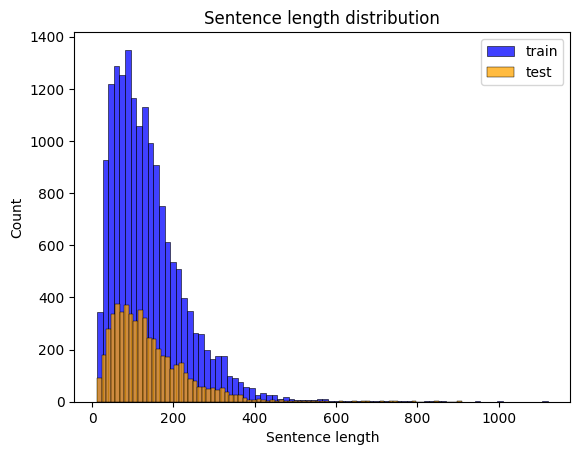

In [ ]:
sns.histplot(df, x=df[df.pool == 'train'].sentence_len, color='blue', bins=80)
sns.histplot(df, x=df[df.pool == 'test'].sentence_len, color='orange', bins=80)
plt.legend(['train', 'test'])
plt.xlabel('Sentence length')
plt.title('Sentence length distribution')

Дальше происходит токенизирование и обучение BERT, со скалированием целевой переменной.
В итоге решил использовать name и description, с добавлением категориальных признаков в текст и key_skills качество в лучшем случае немного ухудшалось.

In [9]:
corpus = tokenizer((train.name+" "+train.description).tolist(),
          add_special_tokens=True,
          padding='max_length',
          truncation='longest_first',
          max_length=512,
          return_attention_mask=True,
          return_tensors='pt')

In [10]:
input_ids = np.array(corpus['input_ids'])
attention_mask = np.array(corpus['attention_mask'])
labels = train.salary.to_numpy()

In [11]:
train_inputs, val_inputs, train_labels, val_labels, train_masks, val_masks = \
            tts(input_ids, labels, attention_mask, train_size=0.9,
                             random_state=68)

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_labels.reshape(-1, 1))
train_labels = scaler.transform(train_labels.reshape(-1, 1))
val_labels = scaler.transform(val_labels.reshape(-1, 1))

In [13]:
import torch
from torch.utils.data import TensorDataset, DataLoader


batch_size = 32
num_workers = 2

def create_dataloaders(inputs, masks, labels, batch_size, shuffle=True):
    input_tensor = torch.tensor(inputs)
    mask_tensor = torch.tensor(masks)
    labels_tensor = torch.tensor(labels)
    dataset = TensorDataset(input_tensor, mask_tensor, labels_tensor)
    dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=shuffle
        )
    return dataloader

train_dataloader = create_dataloaders(train_inputs, train_masks,
                                      train_labels, batch_size)
val_dataloader = create_dataloaders(val_inputs, val_masks,
                                     val_labels, batch_size, shuffle=False)
train_test_dataloader = create_dataloaders(train_inputs, train_masks,
                                      train_labels, batch_size, shuffle=False)

Насчет того, как использовать информацию из берта - веса с последнего выхода показали наилучшие результаты для регрессии в этой задаче.

In [14]:
import torch.nn as nn


if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

class ImportedBERT(nn.Module):

    def __init__(self, drop_rate=0.2):

        super().__init__()
        num_in, num_out = 312, 1

        self.transferred = model
        self.output = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(num_in, num_out))

    def forward(self, input_ids, attention_masks):

        outputs = self.transferred(input_ids, attention_masks)
        class_label_output = outputs[1]
        outputs = self.output(class_label_output)

        return outputs




Using GPU.


In [15]:
import pytorch_lightning as pl
from torch.nn.utils.clip_grad import clip_grad_norm_
from torchmetrics import R2Score
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

class Regressor(pl.LightningModule):

    def __init__(self, model, lr=5e-5, eps=1e-8, n_epochs=3):
        super().__init__()

        self.model = model
        self.optimizer = AdamW(self.model.parameters(), lr=lr, eps=eps)
        self.loss = nn.MSELoss()
        self.eps = eps

    def forward(self, inp, mask):
        return self.model(inp, mask)

    def training_step(self, tr_batch, batch_idx):

        inputs, masks, labels = tr_batch
        outputs = self.model(inputs, masks)
        loss = self.loss(outputs.squeeze().float(), labels.squeeze().float())
#         clip_grad_norm_(model.parameters(), 2)
        score = r2_loss(outputs, labels)

        self.log(
            "train_loss",
            loss,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        self.log(
            "train_r2",
            score,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )

        return loss

    def validation_step(self, val_batch, batch_idx):

        inputs, masks, labels = val_batch
        outputs = self.model(inputs, masks)
        loss = self.loss(outputs.squeeze(), labels.squeeze())
        score = r2_loss(outputs, labels)

        self.log(
            "val_loss",
            loss,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        self.log(
            "val_r2",
            score,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )

        return loss.float()

    def test_step(self, test_batch, batch_idx):
        inputs, masks, labels = test_batch
        outputs = self.model(inputs, masks)
        loss =  self.loss(outputs.squeeze().float(), labels.squeeze().float())

        self.log (
            "predictions",
            outputs.mean(),
            logger=True
        )

        return outputs


    def configure_optimizers(self):

#         scheduler = get_linear_schedule_with_warmup(
#             self.optimizer,
#             num_warmup_steps=0,
#             num_training_steps=self.trainer.estimated_stepping_batches,
#         )
#         scheduler = {"scheduler": scheduler, "interval": "step", "frequency": 1}

        return {"optimizer": self.optimizer,
#                 "lr_scheduler": scheduler,
                "monitor": "r2"}

Модель быстро переобучается, больше 3-4 эпох нет смысла ставить.

In [16]:
bert = ImportedBERT(drop_rate=0.2)
comp = Regressor(bert).to(device)

trainer = pl.Trainer(
    max_epochs=3,
#     logger=wandb_logger,
    enable_checkpointing=True
)

trainer.fit(comp, train_dataloader, val_dataloader)

Sanity Checking: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you

Training: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

In [16]:
trainer.validate(comp, val_dataloader)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │     0.436885241793224     │
│          val_r2           │    0.4340635494807872     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.436885241793224, 'val_r2': 0.4340635494807872}]

In [17]:
def predict(model, dataloader, device):
    model.eval()
    output = []
    for batch in dataloader:
        batch_inputs, batch_masks, _ = \
                                  tuple(b.to(device) for b in batch)
        with torch.no_grad():
            output += model.model(batch_inputs,
                            batch_masks).view(1,-1).tolist()[0]
    return output

y_pred_val = predict(comp.to(device), val_dataloader, device)
y_pred_val = scaler.inverse_transform(np.array(y_pred_val).reshape(-1, 1))
y_pred_train = predict(comp.to(device), train_test_dataloader, device)
y_pred_train = scaler.inverse_transform(np.array(y_pred_train).reshape(-1, 1))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Используя предсказания только берта, получилось выбить следующую точность: 
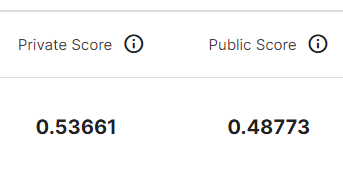

<a id="4"></a> <br>
# 4. BERT+CATBOOST
После этого решил прикрутить предсказания берта к категориальным признакам и обучить catboost.

In [18]:
X_train, X_test, y_train, y_test = tts(X, y, train_size=0.9, random_state=68)

In [19]:
X_train['bert_pred'] = y_pred_train.ravel()
X_test['bert_pred'] = y_pred_val.ravel()

In [20]:
from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred_val))
print(r2_score(y_train, y_pred_train))

0.5285994913568044
0.7826263228835137


In [23]:
X_train['bert_pred'] = y_pred_train
X_train = X_train.drop(columns=['name', 'description', 'key_skills'])
X_train.head()

,experience,schedule,employment,bert_pred
13317,От 1 года до 3 лет,Полный день,Полная занятость,43973.992008
1267,Нет опыта,Полный день,Полная занятость,31346.484647
4898,От 3 до 6 лет,Сменный график,Полная занятость,52555.845282
13310,Нет опыта,Полный день,Полная занятость,40596.370554
16568,Нет опыта,Гибкий график,Частичная занятость,27630.617116


In [24]:
X_test['bert_pred'] = y_pred_val
X_test = X_test.drop(columns=['name', 'description', 'key_skills'])
X_test.head()

,experience,schedule,employment,bert_pred
16436,Более 6 лет,Вахтовый метод,Полная занятость,93886.671697
7093,От 1 года до 3 лет,Полный день,Полная занятость,51042.349838
14200,Нет опыта,Полный день,Полная занятость,28450.841246
6258,От 1 года до 3 лет,Полный день,Полная занятость,65294.630464
4558,От 3 до 6 лет,Вахтовый метод,Полная занятость,93809.640348


In [26]:
from catboost import CatBoostRegressor
from catboost import Pool
import optuna
pool_train = Pool(
    X_train, y_train,
    cat_features=['experience', 'schedule', 'employment']
)
pool_test = Pool(
    X_test, y_test,
    cat_features=['experience', 'schedule', 'employment']
)

In [5]:
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 1, 6),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 10, 5000),
        "cat_features": ['experience', 'schedule', 'employment']
    }

    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    return score

In [6]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2023-08-28 20:23:49,978] A new study created in memory with name: no-name-14847adb-4283-4311-af2a-a6d2c3e9014d


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-08-28 20:23:53,820] Trial 0 finished with value: 0.2682485069307706 and parameters: {'max_depth': 1, 'learning_rate': 0.00026678815683957925, 'n_estimators': 2044}. Best is trial 0 with value: 0.2682485069307706.
[I 2023-08-28 20:23:54,019] Trial 1 finished with value: 0.005929364028257056 and parameters: {'max_depth': 2, 'learning_rate': 0.00010435009264106773, 'n_estimators': 63}. Best is trial 0 with value: 0.2682485069307706.
[I 2023-08-28 20:24:10,161] Trial 2 finished with value: 0.5456883734459005 and parameters: {'max_depth': 3, 'learning_rate': 0.0025964063709833754, 'n_estimators': 3862}. Best is trial 2 with value: 0.5456883734459005.
[I 2023-08-28 20:24:17,079] Trial 3 finished with value: 0.5441507281223643 and parameters: {'max_depth': 2, 'learning_rate': 0.003723410766306495, 'n_estimators': 2294}. Best is trial 2 with value: 0.5456883734459005.
[I 2023-08-28 20:24:26,621] Trial 4 finished with value: 0.5425338381454596 and parameters: {'max_depth': 4, 'learning_

In [31]:
cb = CatBoostRegressor(learning_rate=0.0007339855637725657, iterations=10000)

In [32]:
cb.fit(pool_train, eval_set=pool_test, verbose=500)

0:	learn: 34383.3126996	test: 33104.6747933	best: 33104.6747933 (0)	total: 15.6ms	remaining: 2m 36s
500:	learn: 26489.6109688	test: 27535.1640643	best: 27535.1640643 (500)	total: 7.58s	remaining: 2m 23s
1000:	learn: 21426.4391525	test: 24426.0912234	best: 24426.0912234 (1000)	total: 14.4s	remaining: 2m 9s
1500:	learn: 18384.4137271	test: 22834.8865177	best: 22834.8865177 (1500)	total: 20.6s	remaining: 1m 56s
2000:	learn: 16595.5588854	test: 22047.8963289	best: 22047.8963289 (2000)	total: 26.7s	remaining: 1m 46s
2500:	learn: 15579.3291567	test: 21678.4002925	best: 21678.4002925 (2500)	total: 32.7s	remaining: 1m 37s
3000:	learn: 15004.7219465	test: 21510.1542415	best: 21510.1542415 (3000)	total: 39.2s	remaining: 1m 31s
3500:	learn: 14669.2483291	test: 21433.6978760	best: 21433.6978760 (3500)	total: 44.5s	remaining: 1m 22s
4000:	learn: 14453.3678110	test: 21406.6705976	best: 21406.6705976 (4000)	total: 49.6s	remaining: 1m 14s
4500:	learn: 14317.1777373	test: 21399.7808540	best: 21399.6817

In [49]:
predictions = cb.predict(X_test)

Как видно, r2 немного увеличился.

In [36]:
from sklearn.metrics import r2_score
print(r2_score(y_test, predictions))
print(r2_score(y_test, X_test['bert_pred']))

0.582524726360363
0.5811150952180593


In [37]:
r2_score(y_test, X_test['bert_pred'])

0.5811150952180593

In [39]:
encoded_val_corpus = \
                tokenizer(text=(test.name+" "+test.description).tolist(),
                          add_special_tokens=True,
                          padding='max_length',
                          truncation='longest_first',
                          max_length=512,
                          return_attention_mask=True,
                          return_tensors='pt')
test_input_ids = np.array(encoded_val_corpus['input_ids'])
test_attention_mask = np.array(encoded_val_corpus['attention_mask'])

test_dataloader = create_dataloaders(test_input_ids, 
                                     test_attention_mask,
                                     np.ones(test_input_ids.shape[0]),
                                     batch_size, shuffle=False)
y_pred_test = predict(comp.to(device), test_dataloader, device)
y_pred_test = scaler.inverse_transform(np.array(y_pred_test).reshape(-1, 1))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [44]:
predictions = pd.DataFrame({'id': test.index,
                            'salary': y_pred_test.ravel()})
predictions.to_csv('3epochs_onlybert.csv', index=False)

In [46]:
test_cb = test.drop(columns=['name', 'description', 'key_skills'])
test_cb['bert_pred'] = y_pred_test
test_cb.head()

,id,experience,schedule,employment,bert_pred
0,0,Более 6 лет,Полный день,Полная занятость,52397.092440
1,1,От 1 года до 3 лет,Сменный график,Полная занятость,43332.160474
2,2,От 1 года до 3 лет,Полный день,Полная занятость,39792.405316
3,3,От 1 года до 3 лет,Полный день,Полная занятость,41411.612848
4,4,Нет опыта,Сменный график,Полная занятость,44767.683938


In [52]:
test_cb = test_cb.drop(columns=['id'])

In [55]:
predictions_test_cb = cb.predict(test_cb)

In [57]:
predictions_df = pd.DataFrame({'id': test.index,
                            'salary': predictions_test_cb})
predictions_df.to_csv('3epochsbert+cbr.csv', index=False)

Catboost в связке с bert в итоге оказался точнее: 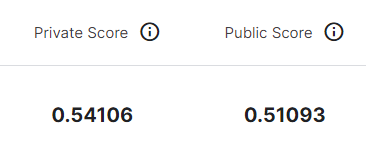